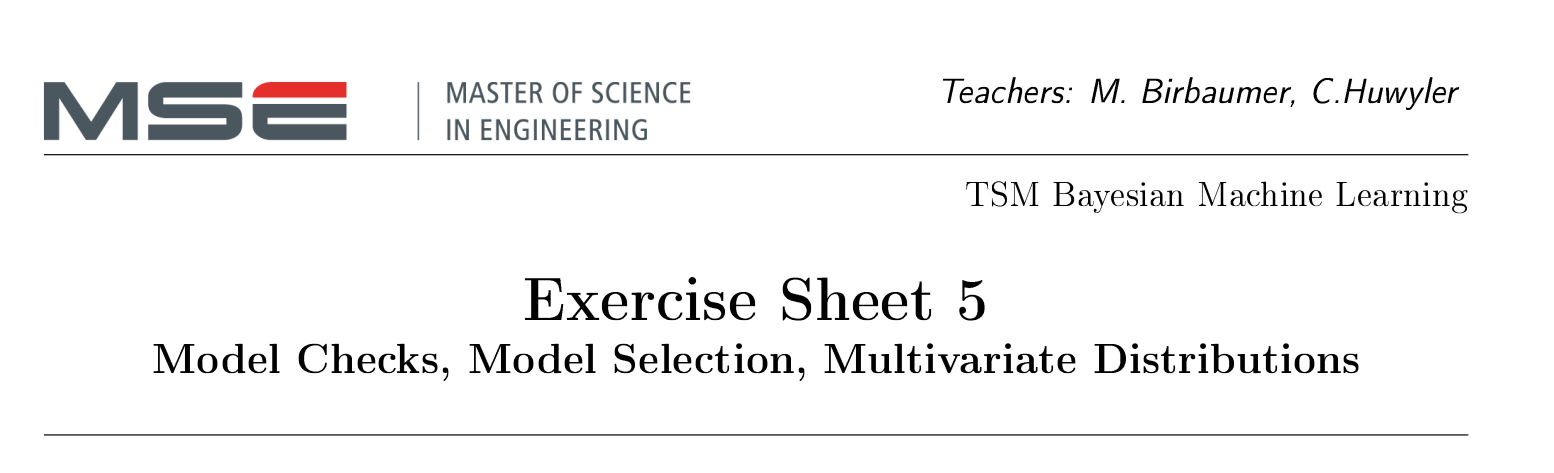

# Solutions

Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
from tqdm.auto import tqdm
import pymc as pm
plt.rcParams["figure.figsize"] = (15,3)
plt.style.use('ggplot')
np.random.seed(1337) # for consistency

## Exercise 1

### a)

No solution, you should check by yourself whether you arrive at the correct result (see lecture slides).

### b)

The Poisson distribution is

$$
\text{Pois}(k|\lambda) = \frac{\lambda^k \, e^{-\lambda}}{k!}
$$

For converging to the Poisson distribution for $r\to\infty$, the following properties need to be shown:

* $\displaystyle{\lim_{r\to\infty} \left(1+\frac{\lambda}{r}\right)^r = e^\lambda}$ (known property of the exponential function, see e.g. Wikipedia)
* $\displaystyle{\frac{(r+k-1)!}{(r-1)!} = \frac{1 \cdot 2 \cdot \dots \cdot (r-1) \cdot r \cdot (r+1) \cdot \dots \cdot (r+k-1)}{1 \cdot 2 \cdot \dots \cdot (r-1)} = (r+1) \cdot \dots \cdot (r+k-1)}$
* $\displaystyle{\lim_{r\to\infty} \frac{r \cdot (r+1) \cdot \dots \cdot (r+k-1)}{(r+\lambda)^k)} = \frac{r^k}{r^k} = 1}$

### c)

Negative binomial likelihood (use $\alpha$ instead of $r$ because $r$ is already used in prior): 

$$k \sim \text{NegBin}(\alpha, \lambda) \propto \frac{\lambda^k}{\left(1+\frac{\lambda}{\alpha}\right)^\alpha}$$

Gamma prior:

$$\lambda \sim \text{Gamma}(s, r) \propto \lambda^{s-1} \, e^{-r\lambda}$$

Resulting posterior:

$$
p(\lambda, \alpha|k) \propto p(k|\lambda) \, p(\lambda) \propto \frac{\lambda^k}{\left(1+\frac{\lambda}{\alpha}\right)^\alpha} \lambda^{s-1} \, e^{-r\lambda} = \frac{\lambda^{s+k+1} \, e^{-r\lambda}}{\left(1+\frac{\lambda}{\alpha}\right)^\alpha}
$$

This is not equal to the kernel of the Gamma distribution and consequently the negative binomial likelihood and the Gamma prior are not conjugated. We necessarily need to run MCMC to get samples from the posterior.

## Exercise 2

Data:

In [2]:
y_obs = np.load( "toilet_paper_data.npy" )
y_obs

array([165.5, 138.7, 139.7, 133.1, 156.4, 118.4, 166.9, 136.9, 149.8,
       143. , 163.5, 121.3, 142.1, 141.4, 159.6, 132.8, 143.9, 135.5,
       146.5, 153. , 132.8, 159.7, 156.8, 152. , 156.8, 137.8, 144.5,
       134.8, 142.8, 152.4, 137.7, 141.2, 137.8, 135.9, 137.9, 145.8,
       132.6, 148.8, 165.9, 154.9, 220. , 135.3, 137. , 166.3, 146.6,
       138.4, 148.3, 171.2, 147.4, 153.4, 149.6, 141.8, 132.3])

### a)

Empirical mean and standard deviation:

In [3]:
ybar = np.mean(y_obs)
sigmahat = np.std(y_obs, ddof=1)

Simulation:

In [4]:
with pm.Model() as tp_model_normal:
    μ = pm.Normal( 'μ', mu=ybar, sigma=sigmahat )
    σ = pm.Exponential( 'σ', lam=1/sigmahat )
    y = pm.Normal( 'y', mu=μ, sigma=σ, observed=y_obs )
    trace_normal = pm.sample( 1000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Marginal distributions and HDIs:

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

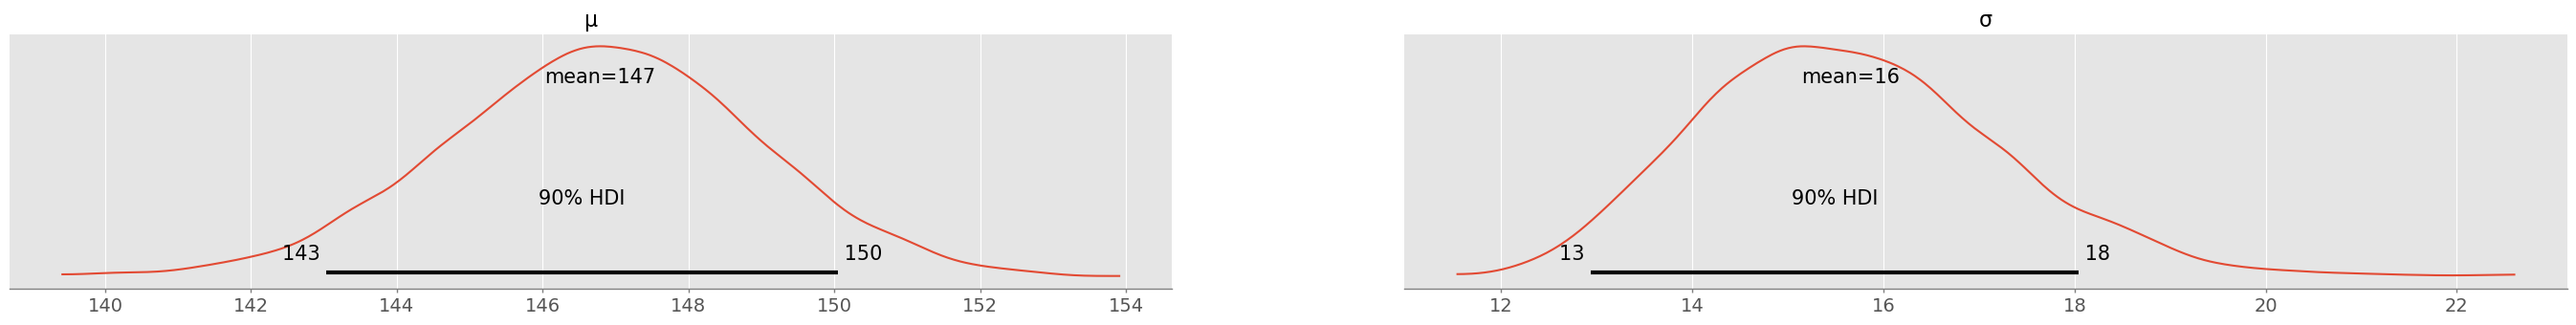

In [5]:
pm.plot_posterior( trace_normal, hdi_prob=0.9 )

In [6]:
pm.summary( trace_normal, hdi_prob=0.9 )

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,146.779,2.139,143.029,150.043,0.036,0.037,3475.0,2674.0,1.0
σ,15.654,1.586,12.941,18.039,0.026,0.027,3728.0,3044.0,1.0


With 90% plausibility, $\mu$ is between 143-150 and $\sigma$ is between 13 and 18 (values might change slightly after running the simulation with a different seed). After a full year of data, there is quite some (aleatoric) uncertainty remaining!

### b)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

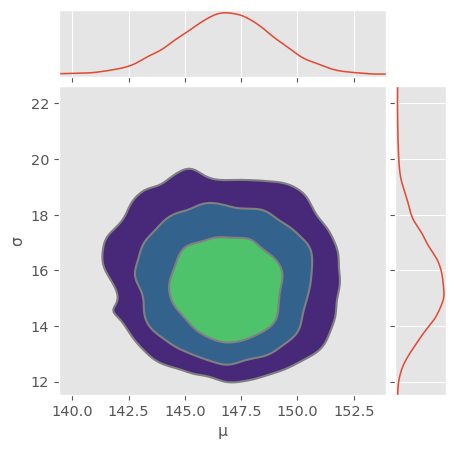

In [7]:
pm.plot_pair( trace_normal, kind="kde", figsize=(5,5), marginals=True )

Looks normally distributed! Note that variances are not equal and you should actually see an ellipse if you turn on equal aspect ratio.

In [8]:
data = np.hstack( [trace_normal.posterior.μ.values.flatten().reshape(-1,1), trace_normal.posterior.σ.values.flatten().reshape(-1,1)] )
C = np.cov( data.T )
C

array([[ 4.5756726 , -0.17370283],
       [-0.17370283,  2.51392661]])

Covariance matrix is almost diagonal! That means there are almost no correlations between $\mu$ and $\sigma$ also in the posterior!

Correlation matrix:

In [9]:
stdevs = np.sqrt(np.diag(C))
C / np.outer(stdevs, stdevs)

array([[ 1.       , -0.0512157],
       [-0.0512157,  1.       ]])

### c)

Compute predictions:

In [10]:
with tp_model_normal:
    ppc_normal = pm.sample_posterior_predictive(trace_normal)

Sampling: [y]


Output()

Reshape predictions for broadcasting with Numpy:

In [11]:
ypred_normal = ppc_normal.posterior_predictive.y.values.reshape(-1,53)
ypred_normal.shape

(4000, 53)

Compute differences:

In [12]:
eps_normal = ypred_normal - y_obs

RMSE (in kg):

In [13]:
np.sqrt( np.mean( eps_normal**2 ) )

np.float64(22.001847895618823)

MAE (in kg):

In [14]:
np.mean( np.abs( eps_normal ) )

np.float64(16.756911889753187)

RMSE and MAE are quite different, this could indicate the presence of outliers in the data..

### d)

<Axes: xlabel='y'>

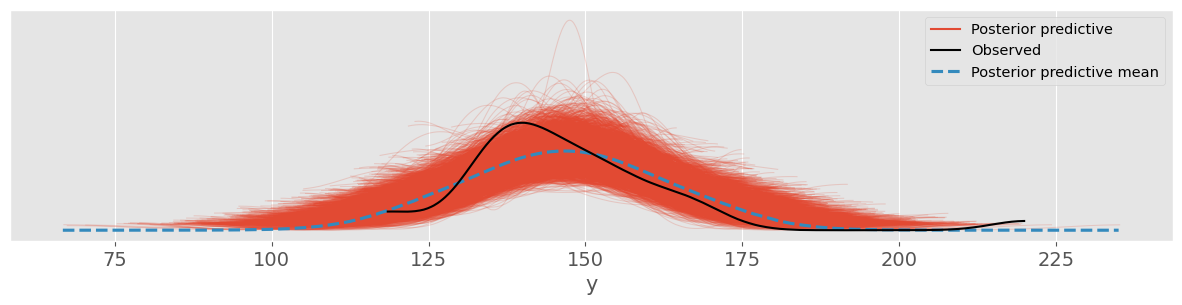

In [15]:
pm.plot_ppc( ppc_normal )

The predictions (red) closely follow a normal distribution. However, the center of the observed data distribution is more to the left! There is an outlier present that can be quickly found (using e.g. a strip plot from seaborn):

<Axes: >

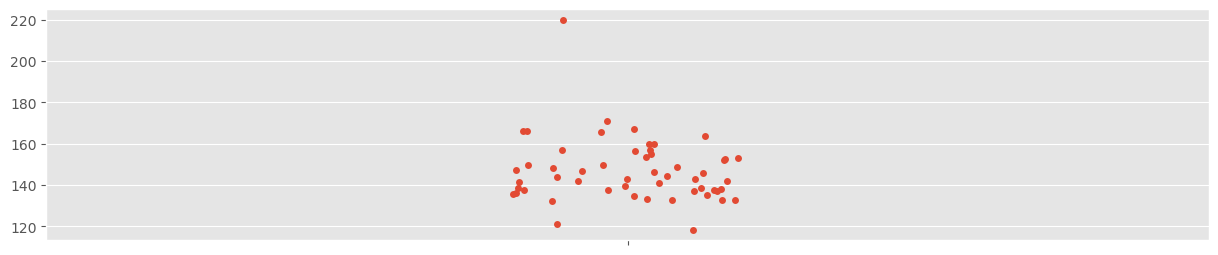

In [16]:
sns.stripplot( y_obs )

This outlier appears to pull the estimate for $\mu$ a bit towards the right. This has not much influence on the estimated mean, but quite some on the estimated standard deviation:

In [17]:
np.std( y_obs, ddof=1 ), np.std( y_obs[y_obs<200], ddof=1 )

(np.float64(15.44934205108168), np.float64(11.683511702453055))

## Exercise 3

### a)

(-4.0, 4.0)

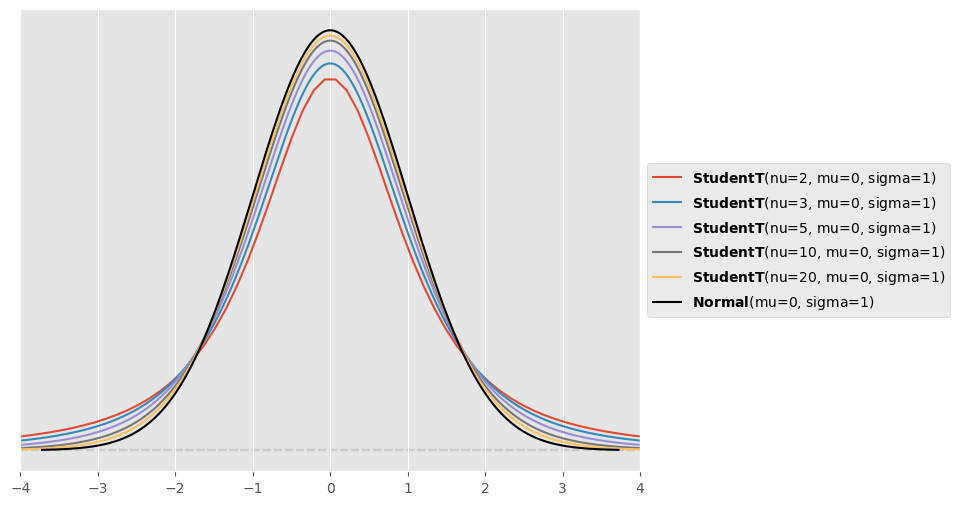

In [18]:
plt.figure( figsize=(8,6) )
for nu in [2,3,5,10,20]:
    pz.StudentT( mu=0, sigma=1, nu=nu ).plot_pdf()
pz.Normal( mu=0, sigma=1 ).plot_pdf( color="black" )
plt.xlim([-4,4])

The Student's $t$ distribution converges towards the normal distribution for large values of $\nu$ (so in theory for $\nu \to \infty$). For smaller values of $\nu$, the Student's $t$ distribution has fatter tails than the normal distribution.

### b)

Prior for $\nu$:

<Axes: >

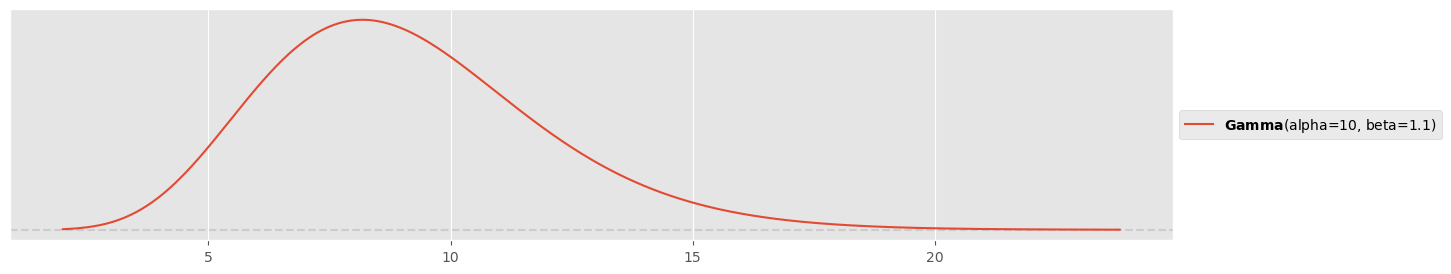

In [19]:
pz.Gamma(10,1.1).plot_pdf()

Simulation:

In [20]:
with pm.Model() as tp_model_studentt:
    μ = pm.Normal( 'μ', mu=ybar, sigma=sigmahat )
    σ = pm.Exponential( 'σ', lam=1/sigmahat )
    ν = pm.Gamma( 'ν', alpha=10, beta=1.1 )
    y = pm.StudentT( 'y', mu=μ, sigma=σ, nu=ν, observed=y_obs )
    trace_studentt = pm.sample( 1000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>,
       <Axes: title={'center': 'ν'}>], dtype=object)

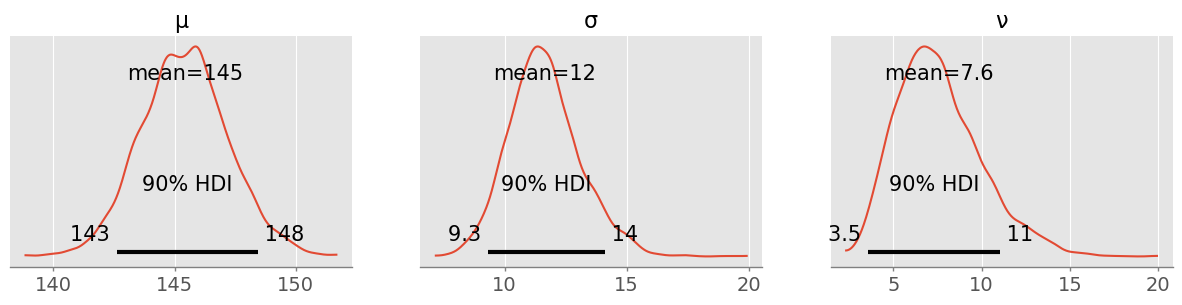

In [21]:
pm.plot_posterior( trace_studentt, figsize=(15,3), hdi_prob=0.9 )

There is slightly less uncertainty in the mean $\mu$ and considerable less uncertainty in $\sigma$ (that was by definition heavily influenced by the outlier)! $\nu$ is with 90% plausibility between 4 and 11, a considerable difference to a normal distribution with fatter tails:

(-4.0, 4.0)

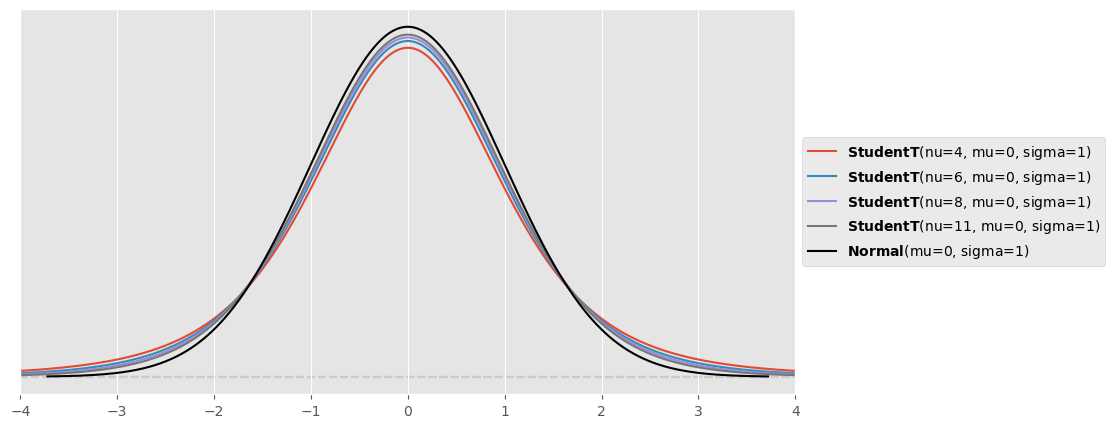

In [22]:
plt.figure( figsize=(10,5) )
for nu in [4,6,8,11]:
    pz.StudentT( mu=0, sigma=1, nu=nu ).plot_pdf()
pz.Normal( mu=0, sigma=1 ).plot_pdf( color="black" )
plt.xlim([-4,4])

The fatter tails allow to accomodate the outlier there, while the normal distribution tries to bring the outlier more within its center.

### c)

In [23]:
with tp_model_studentt:
    ppc_studentt = pm.sample_posterior_predictive(trace_studentt)

Sampling: [y]


Output()

Text(0.5, 1.0, "Student's t likelihood")

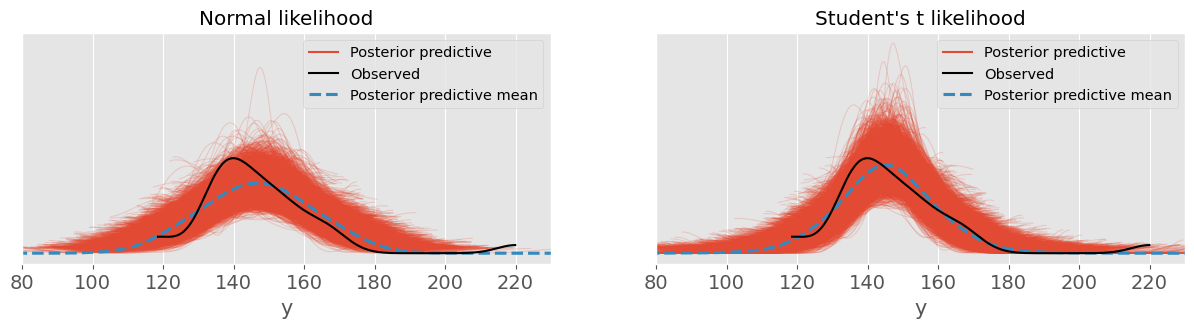

In [24]:
fig, ax = plt.subplots(1, 2, sharey=True )
plt.sca( ax[0] )
pm.plot_ppc( ppc_normal, ax=ax[0] )
plt.xlim(80, 230)
plt.title("Normal likelihood")
plt.sca( ax[1] )
pm.plot_ppc( ppc_studentt, ax=ax[1] )
plt.xlim(80, 230)
plt.title("Student's t likelihood")

Student's $t$ likelihood seems to make predictions quite a bit closer to the data distribution!

### d)

In [25]:
ypred_studentt = ppc_studentt.posterior_predictive.y.values.reshape(-1,53)
eps_studentt = ypred_studentt - y_obs

RMSE:

In [26]:
np.sqrt( np.mean( eps_studentt**2 ) )

np.float64(20.834522351330023)

MAE:

In [27]:
np.mean( np.abs( eps_studentt ) )

np.float64(15.390502135330104)

RMSE and MAE are now of almost equal size. However they are only a bit smaller. Choosing a more complex distribution (3 instead of 2 parameters) comes with more uncertainty in the parameters and consequently more predictive uncertainty for the same amount of data. Even though we have reduced the bias of the model ('wrong' normal likelihood assumption), we have now increased its variance by introducing an additional parameter.

### e)

In [28]:
with tp_model_normal:
    pm.compute_log_likelihood(trace_normal)
loo_normal = pm.loo( trace_normal )

Output()

/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


(this warning is justified!!)

In [29]:
with tp_model_studentt:
    pm.compute_log_likelihood(trace_studentt)
loo_studentt = pm.loo( trace_studentt )

Output()

In [30]:
df_comp_loo = pm.compare({'Normal Likelihood': loo_normal, 'Student\'s t Likelihood': loo_studentt})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student's t Likelihood,0,-216.208607,2.856155,0.000000,1.000000e+00,9.056362,0.000000,False,log
Normal Likelihood,1,-224.336950,5.837058,8.128344,3.996803e-15,14.141412,6.196667,True,log


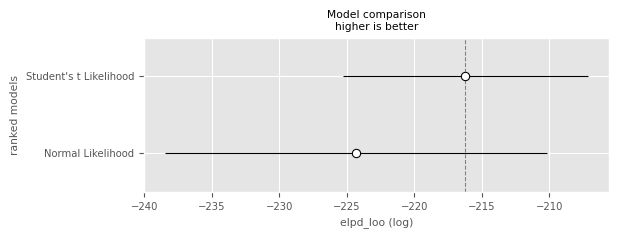

In [31]:
pm.plot_compare(df_comp_loo);

In terms of ELPD, the model with the Student's $t$ likelihood is not significantly better (by the one-standard-error rule) than the model with the normal likelihood. This would probably change with more data and is due to the additional uncertainties (e.g. in the estimation of $\nu$).

## Exercise 4

Data:

In [32]:
y_obs = np.load( "railway_switch_data.npy" )

### a) 

#### Poisson likelihood model:

<Axes: >

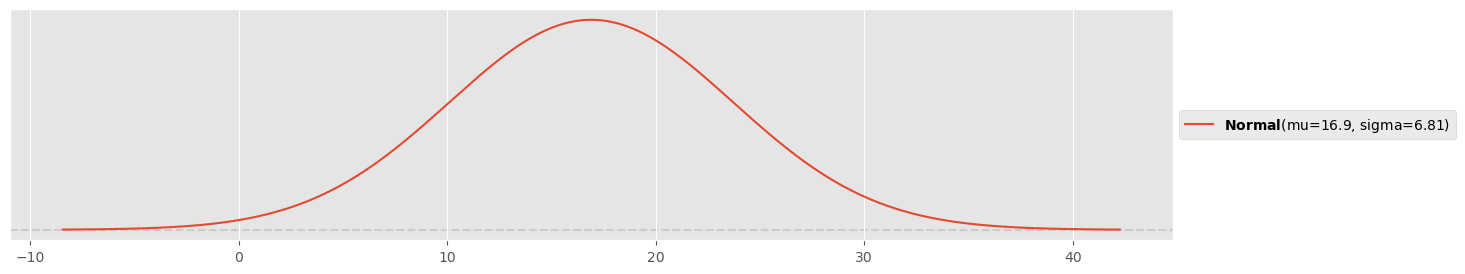

In [33]:
pz.Normal( mu=np.mean(y_obs), sigma=np.std(y_obs) ).plot_pdf()

In [34]:
with pm.Model() as poisson_model:
    lbd = pm.Normal( 'lbd', mu=np.mean(y_obs), sigma=np.std(y_obs) )
    y = pm.Poisson( 'y', mu=lbd, observed=y_obs )
    trace_poisson = pm.sample( 1000, chains=4 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'lbd'}>

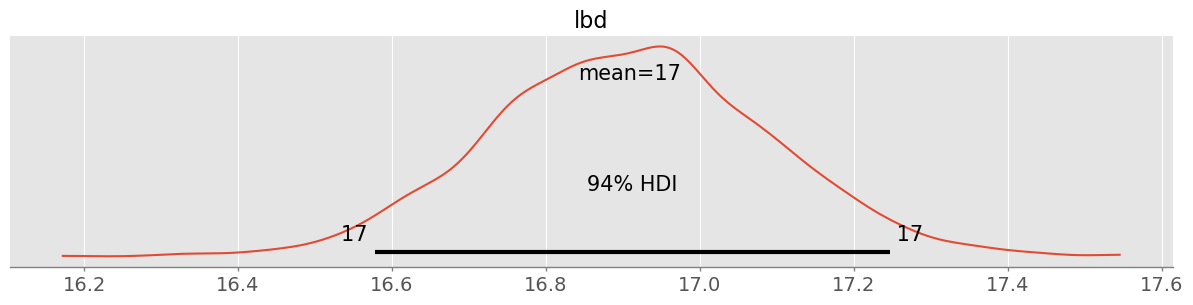

In [35]:
pm.plot_posterior( trace_poisson )

#### Negative binomial likelihood model:

<Axes: >

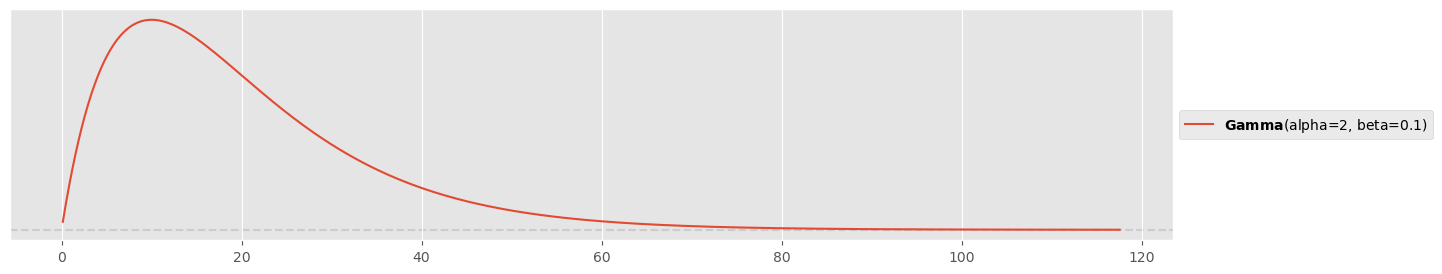

In [36]:
pz.Gamma( alpha=2, beta=0.1 ).plot_pdf()

In [37]:
with pm.Model() as negbin_model:
    lbd = pm.Normal( 'lbd', mu=np.mean(y_obs), sigma=np.std(y_obs) )
    r = pm.Gamma( 'alpha', alpha=2, beta=0.1 )
    y = pm.NegativeBinomial( 'y', mu=lbd, alpha=r, observed=y_obs )
    trace_negbin = pm.sample( 1000, chains=4 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'lbd'}>, <Axes: title={'center': 'alpha'}>],
      dtype=object)

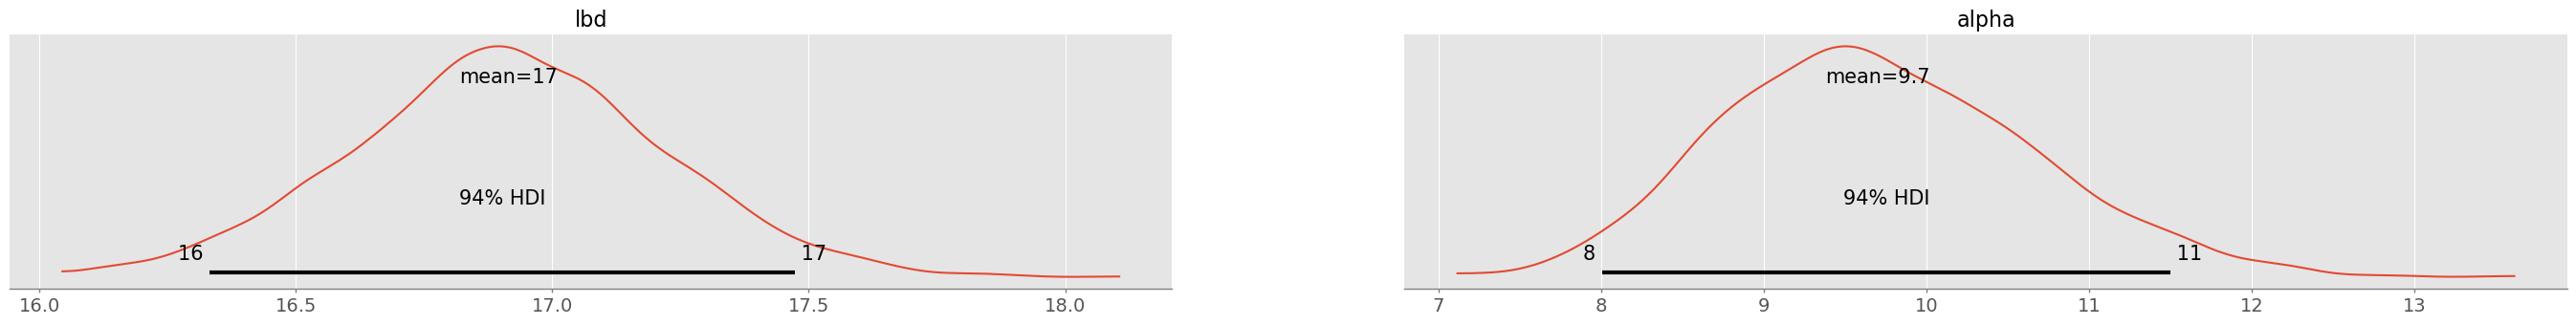

In [38]:
pm.plot_posterior( trace_negbin )

<Axes: xlabel='lbd', ylabel='alpha'>

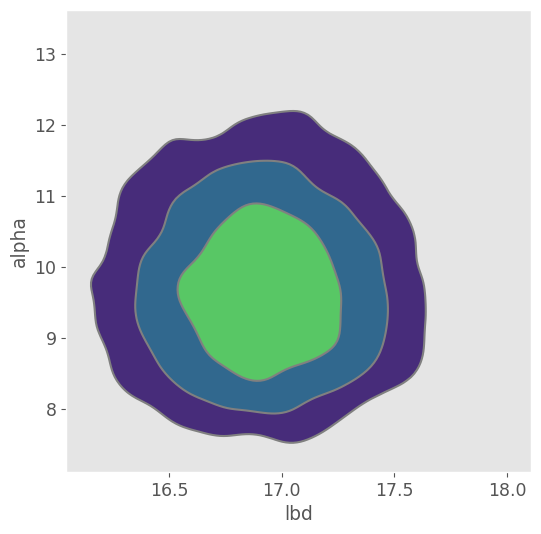

In [39]:
pm.plot_pair( trace_negbin, kind="kde", figsize=(6,6) )

Again the joint posterior distribution looks normally distributed!

### b)

Posterior predictions:

In [40]:
with poisson_model:
    ppc_poisson = pm.sample_posterior_predictive(trace_poisson)

with negbin_model:
    ppc_negbin = pm.sample_posterior_predictive(trace_negbin)

Sampling: [y]


Output()

Sampling: [y]


Output()

Posterior predictive checks:

Text(0.5, 1.0, 'Negative binomial likelihood')

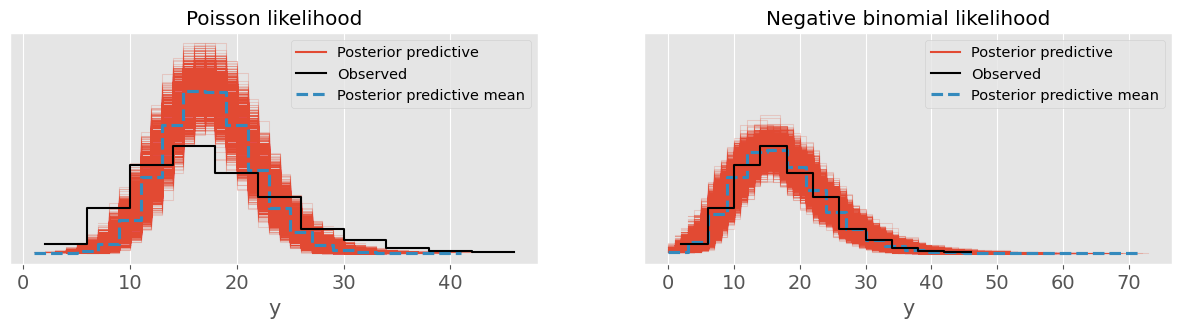

In [41]:
fig, ax = plt.subplots(1, 2, sharey=True )
plt.sca( ax[0] )
pm.plot_ppc( ppc_poisson, ax=ax[0] )
plt.title("Poisson likelihood")
plt.sca( ax[1] )
pm.plot_ppc( ppc_negbin, ax=ax[1] )
plt.title("Negative binomial likelihood")

The negative binomial likelihood seems much better suited to model the data!

### c)

In [42]:
with pm.Model() as poisson_model_smc:
    lbd = pm.Normal( 'lbd', mu=np.mean(y_obs), sigma=np.std(y_obs) )
    y = pm.Poisson( 'y', mu=lbd, observed=y_obs )
    trace_poisson_smc = pm.sample_smc( 2000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [43]:
with pm.Model() as negbin_model_smc:
    lbd = pm.Normal( 'lbd', mu=np.mean(y_obs), sigma=np.std(y_obs) )
    r = pm.Gamma( 'alpha', alpha=2, beta=0.1 )
    y = pm.NegativeBinomial( 'y', mu=lbd, alpha=r, observed=y_obs )
    trace_negbin_smc = pm.sample_smc( 1000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [44]:
lpd1 = trace_poisson_smc.sample_stats.log_marginal_likelihood.mean().values
lpd2 = trace_negbin_smc.sample_stats.log_marginal_likelihood.mean().values
BF = np.exp( lpd2 - lpd1 )
lpd1, lpd2, BF

(array(-1946.6099806),
 array(-1757.12056159),
 np.float64(1.968833791064198e+82))

It is beyond any discussion that the negative binomial model is better suited (BF=$10^{82}$..)

The marginal probabilities are extremely small!

In [45]:
np.exp(lpd1)

np.float64(0.0)

In [46]:
np.exp(lpd2)

np.float64(0.0)

This is the reason why we work with log probabilities, to at least being able to evaluate the Bayes factor. The marginal probabilities are so small because they are the product of the probabilities of all data points under the posterior distribution:

$$
p(d|\mathcal{M}_i) = \prod_{k=1}^N p(y_k|\mathcal{M}_i)
$$

Imagine each data point has on average 80% probability under the model (which is high). Then the resulting marginal probability is

In [47]:
0.8**len(y_obs)

4.342032859091343e-52

extremely small values are to be expected!

### d)

In [48]:
with poisson_model:
    pm.compute_log_likelihood(trace_poisson)
loo_poisson = pm.loo( trace_poisson )

Output()

In [49]:
with negbin_model:
    pm.compute_log_likelihood(trace_negbin)
loo_negbin = pm.loo( trace_negbin )

Output()

In [50]:
df_comp_loo = pm.compare({'Poisson Likelihood': loo_poisson, 'Negative Binomial Likelihood': loo_negbin})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Negative Binomial Likelihood,0,-1753.548028,2.055867,0.000000,0.997327,16.782009,0.000000,False,log
Poisson Likelihood,1,-1944.882660,2.804600,191.334632,0.002673,44.244953,28.150783,False,log


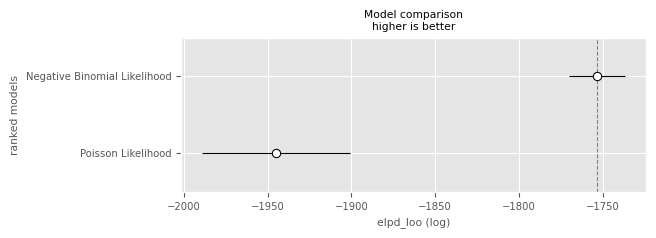

In [51]:
pm.plot_compare(df_comp_loo);

Clearly it is recommended to use the negative binomial model! This time we have enough data to reduce the uncertainty of the additional parameter.

### e)

In [52]:
ypred_poisson = ppc_poisson.posterior_predictive.y.values.reshape(-1,530)
ypred_negbin = ppc_negbin.posterior_predictive.y.values.reshape(-1,530)
eps_poisson = ypred_negbin - y_obs
eps_negbin = ypred_poisson - y_obs

RMSE:

In [53]:
rmse_poisson = np.sqrt( np.mean( eps_poisson**2 ) )
rmse_negbin = np.sqrt( np.mean( eps_negbin**2 ) )
rmse_poisson, rmse_negbin

(np.float64(9.658274558782754), np.float64(7.9643295267913645))

MAE:

In [54]:
mae_poisson = np.mean( np.abs( eps_poisson ) )
mae_negbin = np.mean( np.abs( eps_negbin ) )
mae_poisson, mae_negbin

(np.float64(7.595762735849057), np.float64(6.296092924528302))

Both negative binomial RMSE and MAE are a bit smaller!

## Exercise 5

### a)

In [55]:
observed_counts = [82, 24, 6]

rng = np.random.default_rng(123)

with pm.Model() as churn_model:
    pi = pm.Dirichlet( 'pi', a=[1,1,1] )
    y = pm.Multinomial( 'y', n=np.sum(observed_counts), p=pi, observed=observed_counts )
    trace = pm.sample(1000, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


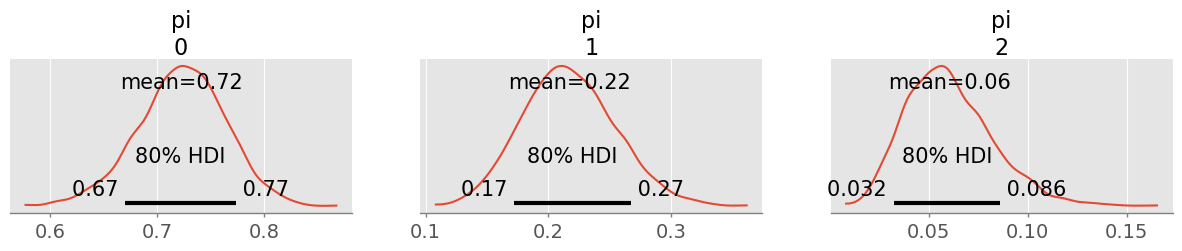

In [56]:
pm.plot_posterior( trace, figsize=(15,2), hdi_prob=0.8 );

I believe to 90% that for around 67-78% of the churn customers the premium is too high, for around 17-27% the coverage was unsufficient and around 0.03-0.09% found our insurance models unsuitable.

### b)

<Axes: title={'center': '$\\bf{Dirichlet}$(alpha=[83. 25.  7.])'}>

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


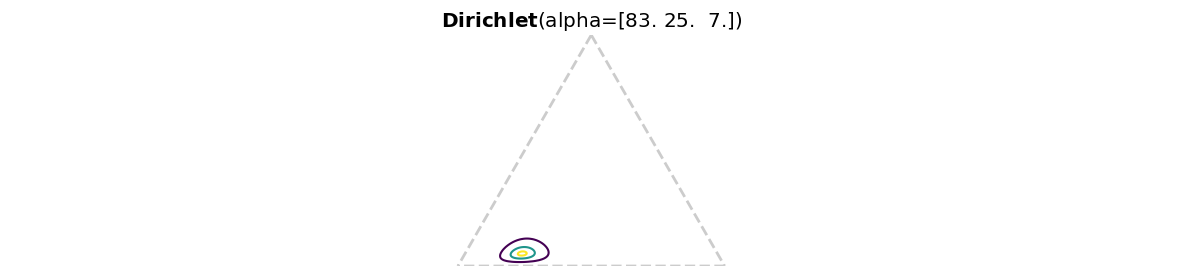

In [57]:
alpha = np.array([1,1,1])
pz.Dirichlet( alpha + observed_counts ).plot_pdf( marginals=False )

### c)

<Axes: title={'center': '$\\bf{Dirichlet}$(alpha=[10.  1.  1.])'}>

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


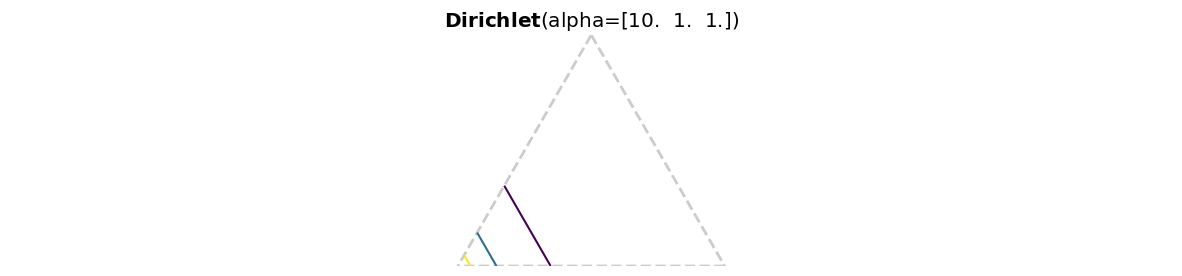

In [58]:
pz.Dirichlet( [10,1,1] ).plot_pdf( marginals=False )

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

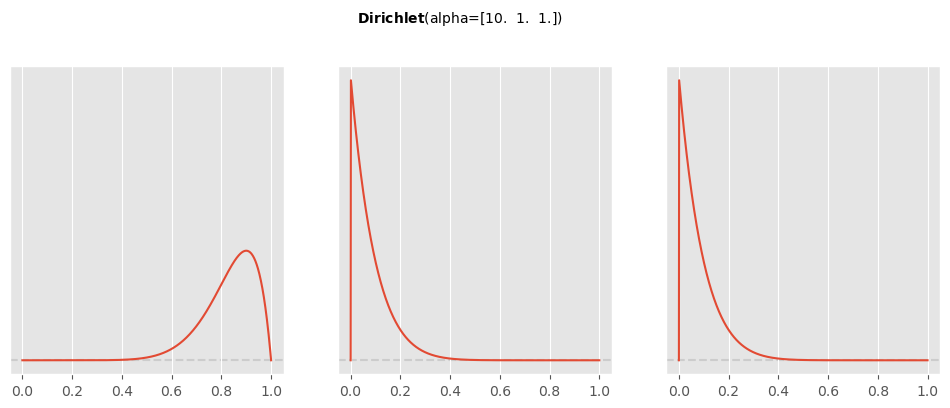

In [59]:
pz.Dirichlet( [10,1,1] ).plot_pdf()

In [60]:
pz.Dirichlet( [10,1,1] ).summary()

Dirichlet(mean=array([0.83333333, 0.08333333, 0.08333333]), std=array([0.10336228, 0.07665552, 0.07665552]))

In [61]:
with pm.Model() as churn_model:
    pi = pm.Dirichlet( 'pi', a=[10,1,1] )
    y = pm.Multinomial( 'y', n=np.sum(observed_counts), p=pi, observed=observed_counts )
    trace = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


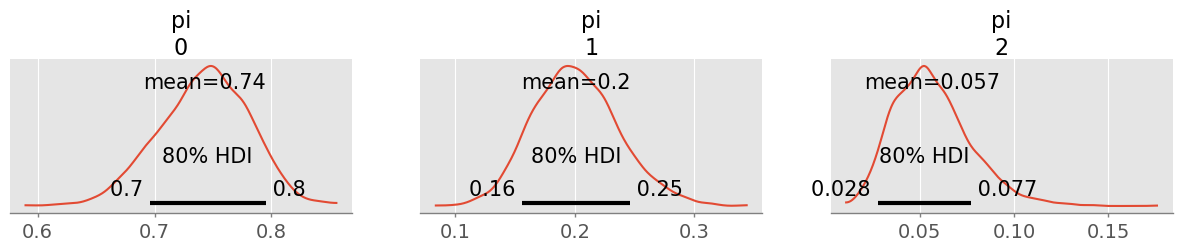

In [62]:
pm.plot_posterior( trace, figsize=(15,2), hdi_prob=0.8 );

90% HDIs are only changed by a few percent! This will not have a big impact on my communication.

## Exercise 6

### a) 

Load data:

In [63]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Compute means and covariance:

In [64]:
mu = credit_data[["Income", "Rating"]].mean().values
mu

array([ 45.218885, 354.94    ])

In [65]:
cov = np.cov( credit_data[["Income", "Rating"]].values.T, ddof=1 )
cov

array([[ 1242.15879093,  4315.49294045],
       [ 4315.49294045, 23939.56030075]])

Plot contour and data (removed equal axis dimensions to make the plot a bit more appealing):

In [66]:
# from notebook "week5_multivariate_distributions.ipynb"
def plot_mvnormal( mu, cov, xrange=[-3,3], yrange=[-3,3], ax=None ):
    
    # setup grid
    x = np.linspace(xrange[0], xrange[1], 1000)
    y = np.linspace(yrange[0], yrange[1], 1000)
    X, Y = np.meshgrid(x, y)

    # multivariate normal
    Z = stats.multivariate_normal( mean=mu, cov=cov ).pdf( np.dstack((X, Y)) )

    # create plot
    if ax is not None:
        plt.sca(ax)

    CS = plt.contour(X, Y, Z, levels=20)
    #plt.gca().set_aspect("equal");

<Axes: xlabel='Income', ylabel='Rating'>

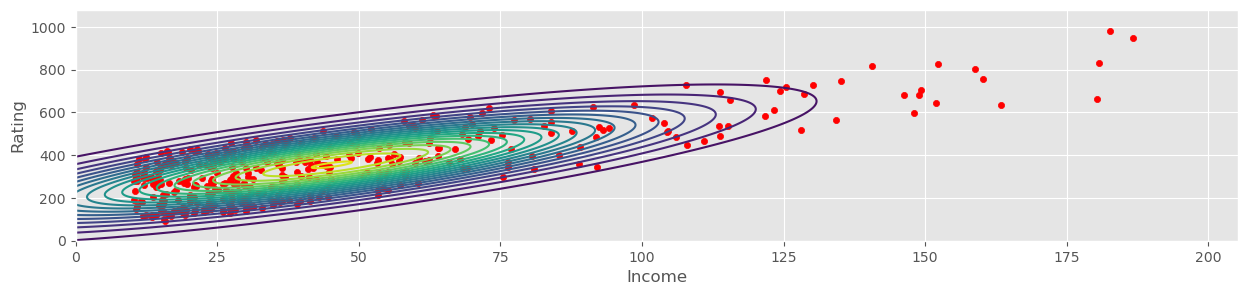

In [67]:
xmin = 0
xmax = credit_data.Income.max() * 1.1
ymin = 0
ymax = credit_data.Rating.max() * 1.1
plot_mvnormal( mu, cov, xrange=[xmin, xmax], yrange=[ymin, ymax] )
credit_data.plot.scatter(x="Income", y="Rating", c="red", ax=plt.gca())

### b)

$$
E[x_1 + x_2] = E[x_1 ]+ E[x_2] = \mu_1 + \mu_2
$$

$$
\text{Var}[x_1 + x_2] = \text{Var}[x_1]+ \text{Var}[x_2] = \sigma_1^2 + \sigma_2^2
$$

$$
\Longrightarrow x_1 + x_2 \sim N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$$

### c)

$$
E[A\,X + \mathbf{b}] = A \boldsymbol{\mu} + \mathbf{b}
$$

$$
\begin{eqnarray}
\text{Cov}[A\,X + \mathbf{b}] &=& \text{Cov}[A\,X]\\
                              &=& E[(A\,X)\,(A\,X)^T] - E[A\,X] \, E[A\,X]^T\\
                              &=& E[A\,X\,X^T\,A^T - A\,E[X]\,E[X]^T\,A^T ]\\
                              &=& A \, E[X\,X^T]\, A^T - A \, E[X] \, E[X]^T \, A^T\\
                              &=& A \, \left( E[X\,X^T] - E[X] \, E[X]^T \right) \, A^T\\
                              &=& A \, \Sigma \, A^T
\end{eqnarray}
$$